In [1]:
# Cell 1 — Install & import dependencies
!pip install -U keras
!pip install -U git+https://github.com/keras-team/keras-hub.git
!pip install tensorflow[and-cuda]  # gives correct CUDA libs automatically

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import keras
import keras_hub

  Cloning https://github.com/keras-team/keras-hub.git to /tmp/pip-req-build-hmozbsli
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-hub.git /tmp/pip-req-build-hmozbsli
  Resolved https://github.com/keras-team/keras-hub.git to commit c7bd26ddbbaf79e710ad35951fa62ccf1255784d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


2025-11-14 15:22:21.512440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 15:22:21.520625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763112141.529368 3005354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763112141.531930 3005354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763112141.539761 3005354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Cell 2 — Display helper (official version)

def display_generated_images(images):
    """Helper function to display the images from the inputs.
    This function accepts:
    - 3D numpy array (H, W, 3)
    - 4D numpy array (N, H, W, 3): concatenated horizontally
    - List of 3D numpy arrays: concatenated horizontally
    """
    display_image = None

    if isinstance(images, np.ndarray):
        if images.ndim == 3:
            display_image = Image.fromarray(images)
        elif images.ndim == 4:
            concated_images = np.concatenate(list(images), axis=1)
            display_image = Image.fromarray(concated_images)

    elif isinstance(images, list):
        concated_images = np.concatenate(images, axis=1)
        display_image = Image.fromarray(concated_images)

    if display_image is None:
        raise ValueError("Unsupported input format.")

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(display_image)
    plt.show()
    plt.close()

In [3]:
# Cell 3 — Load backbone, preprocessor, and inpaint model
backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium",
    image_shape=(512,512,3),
    dtype="float16"
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)
inpaint = keras_hub.models.StableDiffusion3Inpaint(backbone, preprocessor)

I0000 00:00:1763112142.862392 3005354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20695 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-11-14 15:22:23.387123: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [4]:
# Cell 4 — Load & preprocess the reference image + mask
# Replace 'input_image.png' and 'input_mask.png' with your file paths
img = Image.open("biscuit_input.png").convert("RGB")
img = img.resize((512,512))
img_arr = np.array(img).astype("float32")
# rescale to [-1,1]
img_arr = (img_arr / 127.5) - 1.0

mask = Image.open("biscuit_mask.png").convert("L")  # a single‐channel mask
mask = mask.resize((512,512))
mask_arr = np.array(mask)
# set mask to boolean: True where you want to edit (white), False where you keep original (black)
mask_bool = mask_arr > 127  # threshold

Generating with guidance=5.0, strength=0.4


I0000 00:00:1763112155.490534 3005354 service.cc:152] XLA service 0x5b04b430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763112155.490554 3005354 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-14 15:22:36.142802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763112158.422926 3005354 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-14 15:22:41.707184: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2066', 28 bytes spill stores, 28 bytes spill loads

2025-11-14 15:22:41.707486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2066', 32

Generating with guidance=5.0, strength=0.6
Generating with guidance=5.0, strength=0.8
Generating with guidance=7.5, strength=0.4
Generating with guidance=7.5, strength=0.6
Generating with guidance=7.5, strength=0.8
Generating with guidance=10.0, strength=0.4
Generating with guidance=10.0, strength=0.6
Generating with guidance=10.0, strength=0.8


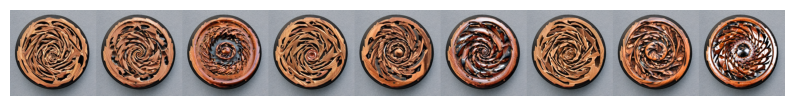

In [5]:
# Cell 5 — Improved inpaint generation (correct scaling)

# prompts = [
    # "A stylish blue Desh Travels bus, parked under a dramatic sunset sky with vibrant orange and purple hues, surrounded by a lush, green countryside road lined with wildflowers. The lighting is soft and warm, emphasizing the bus's sleek design. Cinematic, high detail, photorealistic."
# ]

prompts = ["A macro photograph of an intricate fractal medallion, carved from polished ebony and rosewood. The design is a swirling, nested, organic pattern. Centered, highly detailed, sharp focus, studio lighting, 8k, photorealistic."

]

guidance_scales = [5.0, 7.5, 10.0]
strength_values  = [0.4, 0.6, 0.8]
num_steps = 2000

results = []

for prompt in prompts:
    for gs in guidance_scales:
        for st in strength_values:

            print(f"Generating with guidance={gs}, strength={st}")

            out = inpaint.generate(
                {
                    "images": img_arr,
                    "masks": mask_bool,
                    "prompts": prompt,
                },
                num_steps=num_steps,
                guidance_scale=gs,
                strength=st,
            )

            # ⚠️ NO extra rescaling here.
            # Ensure it's uint8 and drop any batch dim if present.
            out = np.array(out)
            if out.ndim == 4:
                out = out[0]  # (1, H, W, 3) -> (H, W, 3)
            out_uint8 = out.astype("uint8")

            results.append(out_uint8)

# Display all generated images
display_generated_images(np.stack(results, axis=0))

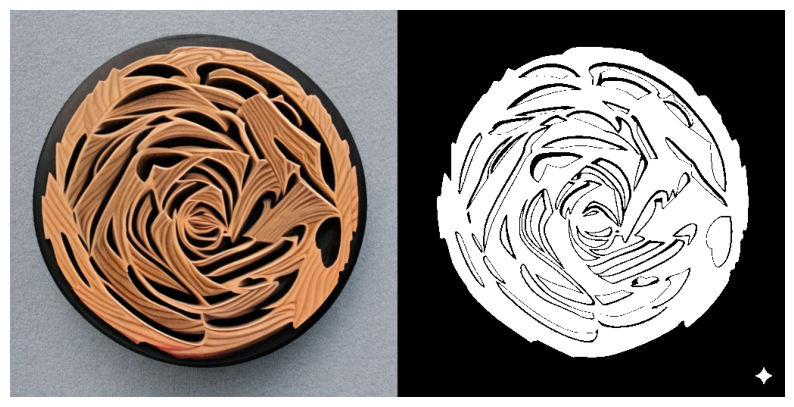

In [6]:
# Cell 6 — Display original image and mask only

orig_uint8 = ((img_arr + 1.0) * 127.5).clip(0,255).astype(np.uint8)
mask_vis   = np.stack([mask_bool.astype(np.uint8)*255]*3, axis=-1)

display_generated_images([orig_uint8, mask_vis])

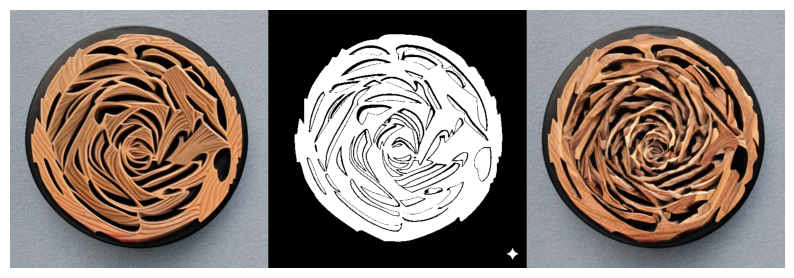

In [7]:
# Cell 6 — Display original image, mask, first generated result

orig_uint8 = ((img_arr + 1.0) * 127.5).clip(0,255).astype(np.uint8)
mask_vis   = np.stack([mask_bool.astype(np.uint8)*255]*3, axis=-1)

first_output = results[0]   # pick first of 9 images

display_generated_images([orig_uint8, mask_vis, first_output])

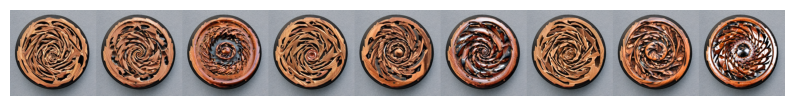

In [8]:
# Cell 6 — Display all generated results (grid)

display_generated_images(results)

In [10]:
# Cell 7 — Save the first generated result

out_img = results[-1]     # pick first generated image
Image.fromarray(out_img).save("inpainted_output_1.png")

print("Saved: inpainted_output_1.png")

Saved: inpainted_output_1.png
